In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
#     eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
#                                                                      labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
#     eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
#                                                                     labels=tf.zeros_like(rates))) # min
#     aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
#                                                                      labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
#     eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
#     aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 aloss:0.6924 eloss:3.6220 aloss2:1.6963 exploreP:0.9984
Episode:1 meanR:18.5000 R:21.0000 rate:0.0420 aloss:0.6903 eloss:3.6280 aloss2:1.6968 exploreP:0.9963
Episode:2 meanR:29.0000 R:50.0000 rate:0.1000 aloss:0.6901 eloss:3.6004 aloss2:1.6963 exploreP:0.9914
Episode:3 meanR:28.5000 R:27.0000 rate:0.0540 aloss:0.6935 eloss:3.5927 aloss2:1.6979 exploreP:0.9888
Episode:4 meanR:25.8000 R:15.0000 rate:0.0300 aloss:0.6877 eloss:3.5463 aloss2:1.6934 exploreP:0.9873
Episode:5 meanR:23.8333 R:14.0000 rate:0.0280 aloss:0.6861 eloss:3.5374 aloss2:1.6942 exploreP:0.9859
Episode:6 meanR:22.4286 R:14.0000 rate:0.0280 aloss:0.6918 eloss:3.5712 aloss2:1.6960 exploreP:0.9846
Episode:7 meanR:23.5000 R:31.0000 rate:0.0620 aloss:0.6902 eloss:3.5379 aloss2:1.6971 exploreP:0.9816
Episode:8 meanR:24.4444 R:32.0000 rate:0.0640 aloss:0.6883 eloss:3.5077 aloss2:1.6955 exploreP:0.9785
Episode:9 meanR:23.8000 R:18.0000 rate:0.0360 aloss:0.6892 eloss:3.5025 aloss2:1.6

Episode:80 meanR:25.0741 R:21.0000 rate:0.0420 aloss:0.6892 eloss:2.6746 aloss2:1.6740 exploreP:0.8180
Episode:81 meanR:24.9390 R:14.0000 rate:0.0280 aloss:0.6883 eloss:2.6639 aloss2:1.6764 exploreP:0.8169
Episode:82 meanR:25.0000 R:30.0000 rate:0.0600 aloss:0.6911 eloss:2.6767 aloss2:1.6767 exploreP:0.8145
Episode:83 meanR:24.9048 R:17.0000 rate:0.0340 aloss:0.6847 eloss:2.6691 aloss2:1.6754 exploreP:0.8131
Episode:84 meanR:24.7765 R:14.0000 rate:0.0280 aloss:0.6788 eloss:2.6742 aloss2:1.6785 exploreP:0.8120
Episode:85 meanR:25.3023 R:70.0000 rate:0.1400 aloss:0.6890 eloss:2.6644 aloss2:1.6758 exploreP:0.8064
Episode:86 meanR:25.1609 R:13.0000 rate:0.0260 aloss:0.6834 eloss:2.6452 aloss2:1.6721 exploreP:0.8054
Episode:87 meanR:25.0682 R:17.0000 rate:0.0340 aloss:0.6926 eloss:2.6506 aloss2:1.6743 exploreP:0.8040
Episode:88 meanR:24.9101 R:11.0000 rate:0.0220 aloss:0.6873 eloss:2.6474 aloss2:1.6755 exploreP:0.8031
Episode:89 meanR:24.8778 R:22.0000 rate:0.0440 aloss:0.6860 eloss:2.6278 

Episode:159 meanR:33.0800 R:40.0000 rate:0.0800 aloss:0.6754 eloss:2.7539 aloss2:1.6574 exploreP:0.6235
Episode:160 meanR:33.2500 R:31.0000 rate:0.0620 aloss:0.6720 eloss:2.7638 aloss2:1.6618 exploreP:0.6216
Episode:161 meanR:33.0300 R:28.0000 rate:0.0560 aloss:0.6818 eloss:2.7668 aloss2:1.6612 exploreP:0.6199
Episode:162 meanR:33.2100 R:38.0000 rate:0.0760 aloss:0.6755 eloss:2.7815 aloss2:1.6616 exploreP:0.6176
Episode:163 meanR:33.4200 R:49.0000 rate:0.0980 aloss:0.6751 eloss:2.7728 aloss2:1.6619 exploreP:0.6146
Episode:164 meanR:33.6200 R:53.0000 rate:0.1060 aloss:0.6738 eloss:2.7807 aloss2:1.6585 exploreP:0.6114
Episode:165 meanR:33.7200 R:27.0000 rate:0.0540 aloss:0.6797 eloss:2.7651 aloss2:1.6610 exploreP:0.6098
Episode:166 meanR:34.2700 R:67.0000 rate:0.1340 aloss:0.6839 eloss:2.7862 aloss2:1.6573 exploreP:0.6058
Episode:167 meanR:34.2300 R:24.0000 rate:0.0480 aloss:0.6772 eloss:2.7750 aloss2:1.6619 exploreP:0.6044
Episode:168 meanR:34.2300 R:31.0000 rate:0.0620 aloss:0.6788 elo

Episode:238 meanR:48.2900 R:62.0000 rate:0.1240 aloss:0.6757 eloss:2.5965 aloss2:1.6626 exploreP:0.4282
Episode:239 meanR:48.7400 R:57.0000 rate:0.1140 aloss:0.6766 eloss:2.5943 aloss2:1.6641 exploreP:0.4258
Episode:240 meanR:48.5400 R:34.0000 rate:0.0680 aloss:0.6707 eloss:2.5784 aloss2:1.6647 exploreP:0.4244
Episode:241 meanR:49.3700 R:102.0000 rate:0.2040 aloss:0.6755 eloss:2.5838 aloss2:1.6621 exploreP:0.4202
Episode:242 meanR:49.8600 R:77.0000 rate:0.1540 aloss:0.6770 eloss:2.5902 aloss2:1.6629 exploreP:0.4170
Episode:243 meanR:50.4100 R:97.0000 rate:0.1940 aloss:0.6788 eloss:2.5835 aloss2:1.6617 exploreP:0.4131
Episode:244 meanR:50.7000 R:65.0000 rate:0.1300 aloss:0.6812 eloss:2.5806 aloss2:1.6572 exploreP:0.4105
Episode:245 meanR:50.5900 R:51.0000 rate:0.1020 aloss:0.6803 eloss:2.5799 aloss2:1.6601 exploreP:0.4085
Episode:246 meanR:51.0500 R:59.0000 rate:0.1180 aloss:0.6791 eloss:2.5745 aloss2:1.6634 exploreP:0.4061
Episode:247 meanR:51.5000 R:63.0000 rate:0.1260 aloss:0.6779 el

Episode:317 meanR:49.3600 R:42.0000 rate:0.0840 aloss:0.6819 eloss:2.4735 aloss2:1.6590 exploreP:0.2921
Episode:318 meanR:49.7200 R:61.0000 rate:0.1220 aloss:0.6760 eloss:2.4735 aloss2:1.6599 exploreP:0.2904
Episode:319 meanR:49.9100 R:49.0000 rate:0.0980 aloss:0.6767 eloss:2.4655 aloss2:1.6630 exploreP:0.2890
Episode:320 meanR:49.8600 R:39.0000 rate:0.0780 aloss:0.6750 eloss:2.4680 aloss2:1.6563 exploreP:0.2879
Episode:321 meanR:49.7000 R:46.0000 rate:0.0920 aloss:0.6726 eloss:2.4683 aloss2:1.6571 exploreP:0.2866
Episode:322 meanR:49.9300 R:50.0000 rate:0.1000 aloss:0.6794 eloss:2.4676 aloss2:1.6572 exploreP:0.2853
Episode:323 meanR:50.3200 R:70.0000 rate:0.1400 aloss:0.6729 eloss:2.4603 aloss2:1.6638 exploreP:0.2833
Episode:324 meanR:50.1300 R:39.0000 rate:0.0780 aloss:0.6683 eloss:2.4619 aloss2:1.6655 exploreP:0.2823
Episode:325 meanR:50.3800 R:65.0000 rate:0.1300 aloss:0.6724 eloss:2.4688 aloss2:1.6584 exploreP:0.2805
Episode:326 meanR:50.2500 R:34.0000 rate:0.0680 aloss:0.6713 elo

Episode:396 meanR:57.6900 R:82.0000 rate:0.1640 aloss:0.6695 eloss:2.4132 aloss2:1.6655 exploreP:0.1870
Episode:397 meanR:58.2200 R:115.0000 rate:0.2300 aloss:0.6681 eloss:2.4024 aloss2:1.6648 exploreP:0.1850
Episode:398 meanR:57.7600 R:50.0000 rate:0.1000 aloss:0.6768 eloss:2.4156 aloss2:1.6653 exploreP:0.1841
Episode:399 meanR:57.6100 R:51.0000 rate:0.1020 aloss:0.6671 eloss:2.4063 aloss2:1.6658 exploreP:0.1832
Episode:400 meanR:57.7800 R:70.0000 rate:0.1400 aloss:0.6782 eloss:2.4087 aloss2:1.6585 exploreP:0.1820
Episode:401 meanR:58.1600 R:74.0000 rate:0.1480 aloss:0.6702 eloss:2.4097 aloss2:1.6643 exploreP:0.1808
Episode:402 meanR:58.4600 R:86.0000 rate:0.1720 aloss:0.6683 eloss:2.3997 aloss2:1.6637 exploreP:0.1793
Episode:403 meanR:58.6900 R:80.0000 rate:0.1600 aloss:0.6720 eloss:2.4057 aloss2:1.6654 exploreP:0.1779
Episode:404 meanR:59.1100 R:83.0000 rate:0.1660 aloss:0.6710 eloss:2.4117 aloss2:1.6657 exploreP:0.1766
Episode:405 meanR:59.3800 R:63.0000 rate:0.1260 aloss:0.6739 el

Episode:475 meanR:82.2400 R:70.0000 rate:0.1400 aloss:0.6725 eloss:2.3707 aloss2:1.6648 exploreP:0.0993
Episode:476 meanR:82.3100 R:48.0000 rate:0.0960 aloss:0.6706 eloss:2.3615 aloss2:1.6639 exploreP:0.0989
Episode:477 meanR:81.7900 R:48.0000 rate:0.0960 aloss:0.6749 eloss:2.3892 aloss2:1.6659 exploreP:0.0985
Episode:478 meanR:82.0100 R:80.0000 rate:0.1600 aloss:0.6744 eloss:2.3740 aloss2:1.6660 exploreP:0.0978
Episode:479 meanR:82.3300 R:78.0000 rate:0.1560 aloss:0.6728 eloss:2.3554 aloss2:1.6657 exploreP:0.0971
Episode:480 meanR:82.4700 R:74.0000 rate:0.1480 aloss:0.6763 eloss:2.3796 aloss2:1.6652 exploreP:0.0964
Episode:481 meanR:82.9900 R:114.0000 rate:0.2280 aloss:0.6777 eloss:2.3895 aloss2:1.6605 exploreP:0.0954
Episode:482 meanR:82.6600 R:68.0000 rate:0.1360 aloss:0.6842 eloss:2.3643 aloss2:1.6651 exploreP:0.0949
Episode:483 meanR:82.8200 R:55.0000 rate:0.1100 aloss:0.6752 eloss:2.3680 aloss2:1.6640 exploreP:0.0944
Episode:484 meanR:82.3600 R:39.0000 rate:0.0780 aloss:0.6726 el

Episode:554 meanR:84.8300 R:75.0000 rate:0.1500 aloss:0.6740 eloss:2.3555 aloss2:1.6676 exploreP:0.0550
Episode:555 meanR:85.9000 R:181.0000 rate:0.3620 aloss:0.6604 eloss:2.3374 aloss2:1.6678 exploreP:0.0541
Episode:556 meanR:85.9600 R:77.0000 rate:0.1540 aloss:0.6586 eloss:2.3205 aloss2:1.6647 exploreP:0.0538
Episode:557 meanR:86.4200 R:129.0000 rate:0.2580 aloss:0.6615 eloss:2.3286 aloss2:1.6685 exploreP:0.0532
Episode:558 meanR:86.4500 R:52.0000 rate:0.1040 aloss:0.6683 eloss:2.3480 aloss2:1.6662 exploreP:0.0530
Episode:559 meanR:85.7500 R:67.0000 rate:0.1340 aloss:0.6553 eloss:2.2939 aloss2:1.6652 exploreP:0.0527
Episode:560 meanR:86.6100 R:181.0000 rate:0.3620 aloss:0.6579 eloss:2.3231 aloss2:1.6623 exploreP:0.0520
Episode:561 meanR:86.8900 R:99.0000 rate:0.1980 aloss:0.6646 eloss:2.3369 aloss2:1.6637 exploreP:0.0516
Episode:562 meanR:87.0200 R:60.0000 rate:0.1200 aloss:0.6547 eloss:2.2995 aloss2:1.6685 exploreP:0.0513
Episode:563 meanR:87.3200 R:94.0000 rate:0.1880 aloss:0.6471 

Episode:633 meanR:110.0400 R:55.0000 rate:0.1100 aloss:0.6531 eloss:2.2639 aloss2:1.6728 exploreP:0.0281
Episode:634 meanR:110.2400 R:78.0000 rate:0.1560 aloss:0.6574 eloss:2.2772 aloss2:1.6677 exploreP:0.0279
Episode:635 meanR:111.0100 R:143.0000 rate:0.2860 aloss:0.6458 eloss:2.3016 aloss2:1.6702 exploreP:0.0277
Episode:636 meanR:110.4500 R:82.0000 rate:0.1640 aloss:0.6565 eloss:2.3028 aloss2:1.6670 exploreP:0.0275
Episode:637 meanR:110.4300 R:115.0000 rate:0.2300 aloss:0.6433 eloss:2.2851 aloss2:1.6736 exploreP:0.0273
Episode:638 meanR:113.5200 R:414.0000 rate:0.8280 aloss:0.6552 eloss:2.2918 aloss2:1.6717 exploreP:0.0266
Episode:639 meanR:113.9200 R:135.0000 rate:0.2700 aloss:0.6427 eloss:2.2710 aloss2:1.6748 exploreP:0.0264
Episode:640 meanR:114.1000 R:105.0000 rate:0.2100 aloss:0.6430 eloss:2.2677 aloss2:1.6700 exploreP:0.0262
Episode:641 meanR:114.4700 R:105.0000 rate:0.2100 aloss:0.6395 eloss:2.2749 aloss2:1.6740 exploreP:0.0261
Episode:642 meanR:114.8300 R:113.0000 rate:0.2260

Episode:711 meanR:169.1000 R:264.0000 rate:0.5280 aloss:0.6284 eloss:2.1901 aloss2:1.6819 exploreP:0.0142
Episode:712 meanR:169.0400 R:88.0000 rate:0.1760 aloss:0.6087 eloss:2.1501 aloss2:1.6841 exploreP:0.0142
Episode:713 meanR:171.0300 R:265.0000 rate:0.5300 aloss:0.6221 eloss:2.1921 aloss2:1.6833 exploreP:0.0141
Episode:714 meanR:171.8200 R:174.0000 rate:0.3480 aloss:0.6144 eloss:2.1967 aloss2:1.6867 exploreP:0.0140
Episode:715 meanR:171.5400 R:146.0000 rate:0.2920 aloss:0.6243 eloss:2.1724 aloss2:1.6850 exploreP:0.0140
Episode:716 meanR:173.6600 R:301.0000 rate:0.6020 aloss:0.6197 eloss:2.1812 aloss2:1.6819 exploreP:0.0139
Episode:717 meanR:174.7300 R:218.0000 rate:0.4360 aloss:0.6107 eloss:2.1642 aloss2:1.6814 exploreP:0.0138
Episode:718 meanR:175.7000 R:167.0000 rate:0.3340 aloss:0.6179 eloss:2.2054 aloss2:1.6860 exploreP:0.0137
Episode:719 meanR:175.7500 R:163.0000 rate:0.3260 aloss:0.6197 eloss:2.1605 aloss2:1.6857 exploreP:0.0136
Episode:720 meanR:175.9900 R:106.0000 rate:0.21

Episode:789 meanR:266.4000 R:475.0000 rate:0.9500 aloss:0.5541 eloss:1.8956 aloss2:1.6977 exploreP:0.0105


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

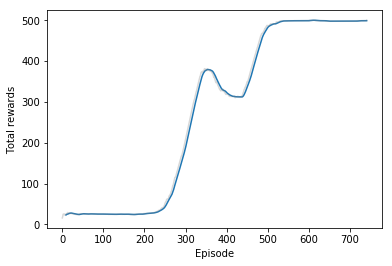

In [23]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

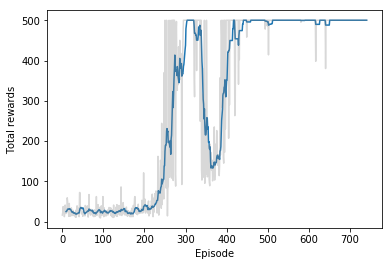

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

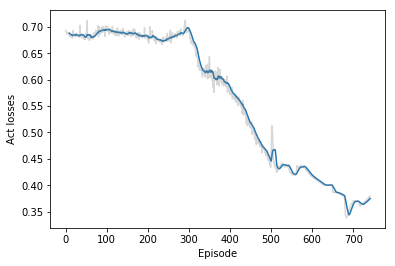

In [25]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

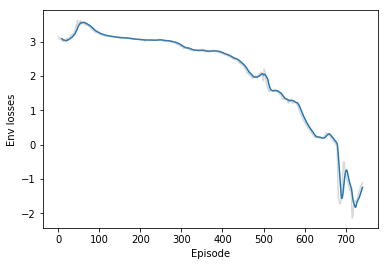

In [26]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

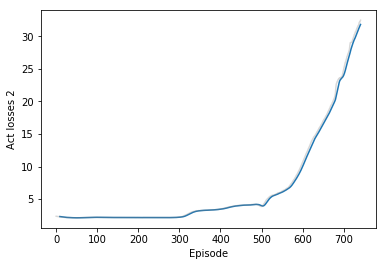

In [27]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
